In [189]:
import pandas as pd
import numpy as np

### Raw data
* x = right from BEV
* y = front from BEV

In [349]:
obj = ['bigt', 'mb', 'mb', 'c', 'c', 'c', 'c', 'c', 't', 'c','bigt']

# real distance (top view) in metres based on PCD
# front center of bus  ---> to centroid of object (then take point on the surface of obj)
#right
x = np.array([27, 4.5, 4, 4, 2.5, 3, 3, 3, 1.8, 16.5, 20 ])
#front
y = np.array([22, 4.5, 13, 4, 4.5, 15, 21, 30, 17, 5.5, 19 ])

# image x, y (take the center bottom of box)
ix = np.array([816, 864, 616, 817, 668, 600, 566, 550, 583, 890, 770])
iy = np.array([309, 407, 331, 424, 353, 326, 312, 298, 323, 332, 308])

### Calculate r, rotate image 3 clockwise

In [350]:
data = pd.DataFrame([x,y,ix,iy]).T
data.columns = ['x','y','imx','imy']
data['r'] = np.sqrt(np.square(data.x) + np.square(data.y))
# rotate object position in image frame 3 degrees
# by adjusting imY only. Only works for bottom right quadrant
data['imy_rot'] = data.imy - np.tan(np.pi/60)*(data.imx-480)

### Undistort x,y

In [351]:
def undistorted(cols):
    w,h=960,604
    k1,k2=-0.9,0.55
    p1,p2=0,0
    x = cols[0]/float(w)
    y = cols[1]/float(h)
    cx,cy = 0.5,0.5
    r2 = ((x-cx)*2 + (y-cy)*2)
    ux = cx + (x-cx)/(1+k1*r2 + k2*(r2**2))
    uy = cy + (y-cy)/(1+k1*r2 + k2*(r2**2))
    return [int(ux*w), int(uy*h)]

In [352]:
data['imx_ud'] = 0
data['imy_ud'] = 0
data[['imx_ud','imy_ud']] = pd.DataFrame(data[['imx','imy']].apply(undistorted, axis=1).tolist())

---
### Method 1: Predict x,y from y position
#### y prediction

In [395]:
H = 2 # H is the height of the camera, also a scale factor
a = -0.9 # a is the "bias" term
yfov = np.pi/1.5*1208/1920
ycenter = 275/604 #y value of center of camera (i.e. horizon)
data['y_pred'] = H / (np.tan(yfov/2)*((data.imy/604 - ycenter)/ycenter)) + a

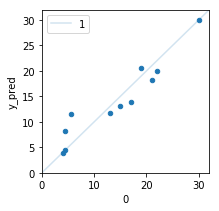

In [396]:
ax = data.plot.scatter(x='y', y='y_pred', figsize=(3,3))
pd.DataFrame([[0,0],[99,99]]).plot(x=0,y=1,ax=ax, alpha=0.2)
ax.set_ylim(0,32); ax.set_xlim(0,32);

Optimizing H and a

In [355]:
y = data['y']
def y_error(H, a, imy):
    y_pred = H / (np.tan(yfov/2)*((imy - ycenter)/ycenter)) + a
    error = np.abs(y_pred - y)
    return error.mean(), error.max(), (error/y).mean()

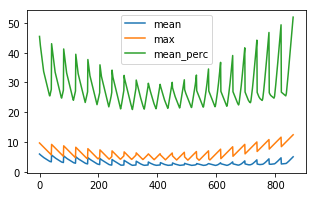

In [356]:
# using distorted imy
H_range = np.linspace(150, 250, int((250-150)/5)+1)/100
a_range = np.linspace(-2,2,41)

error_list = []
param_list = []
for H in H_range:
    for a in a_range:
        e = y_error(H, a, data.imy_ud)
        error_list.append([e[0],e[1],e[2]])
        param_list.append((H,np.round(a,3)))

error_data = pd.DataFrame(np.array(error_list), columns=['mean','max','mean_perc'])
error_data['mean_perc'] = error_data['mean_perc'] * 100
error_data.plot(figsize=(5,3));

Top 5 (H,a) values

In [357]:
table = pd.DataFrame([param_list, [x[2] for x in error_list]]).T
table.columns = ['(H,a)','mean % error']
table.sort_values('mean % error', ascending=True).head()

,"(H,a)",mean % error
315,"(1.85, 0.8)",0.208489
355,"(1.9, 0.7)",0.209823
275,"(1.8, 0.9)",0.210672
395,"(1.95, 0.6)",0.211158
314,"(1.85, 0.7)",0.211476


---
#### x prediction

In [502]:
G = 32 # scale factor
b = -34 # biase
data['x_pred'] = G * (data.imx/960) / (data.imy/604) + b

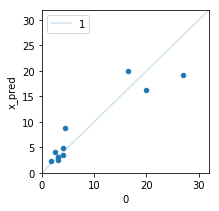

In [503]:
ax = data.plot.scatter(x='x', y='x_pred', figsize=(3,3))
pd.DataFrame([[0,0],[99,99]]).plot(x=0,y=1,ax=ax, alpha=0.2)
ax.set_ylim(0,32); ax.set_xlim(0,32);

Optimizing G and b

In [432]:
x = data['x']
def x_error(G, b, imx, imy):
    x_pred = G * (imx/960) / (imy/604) + b
    error = np.abs(x_pred - x)
    return error.mean(), error.max(), (error/x).mean()

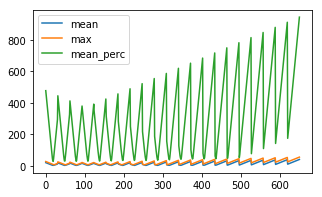

In [462]:
# using distorted imx
G_range = np.linspace(20,40,21)
b_range = np.linspace(-40,-10,31)

error_list = []
param_list = []
for G in G_range:
    for b in b_range:
        e = x_error(G, b, data.imx_ud, data.imy_ud)
        error_list.append([e[0],e[1],e[2]])
        param_list.append((G,np.round(b,3)))

error_datax = pd.DataFrame(np.array(error_list), columns=['mean','max','mean_perc'])
error_datax['mean_perc'] = error_datax['mean_perc'] * 100
error_datax.plot(figsize=(5,3));

Top 5 param values (G,b)

In [499]:
table = pd.DataFrame([param_list, [x[1] for x in error_list]]).T
table.columns = ['(G,b)','mean % error']
table['mean % error'] = table['mean % error']*100
table.sort_values('mean % error', ascending=True).head()

,"(G,b)",mean % error
224,"(27.0, -33.0)",517.175
253,"(28.0, -35.0)",518.685
195,"(26.0, -31.0)",520.243
166,"(25.0, -29.0)",523.311
137,"(24.0, -27.0)",526.378


---
#### combine x and y prediction to get r (i.e. distance) predictions

In [376]:
data.head()

,x,y,imx,imy,r,imy_rot,imx_ud,imy_ud,y_pred,x_pred
0,27.0,22.0,816.0,309.0,34.828150,291.390986,1007,312,19.992201,18.174757
1,4.5,4.5,864.0,407.0,6.363961,386.875413,1035,453,4.481325,8.334152
2,4.0,13.0,616.0,331.0,13.601471,323.872542,664,341,11.784551,3.359517
3,4.0,4.0,817.0,424.0,5.656854,406.338578,977,482,3.867348,4.610849
4,2.5,4.5,668.0,353.0,5.147815,343.147337,761,378,8.206857,3.954674


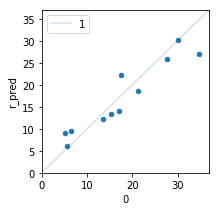

In [377]:
data['r_pred'] = np.sqrt(data['y_pred']**2 + data['x_pred']**2)
ax = data.plot.scatter(x='r', y='r_pred', figsize=(3,3))
pd.DataFrame([[0,0],[99,99]]).plot(x=0,y=1,ax=ax, alpha=0.2)
ax.set_ylim(0,37); ax.set_xlim(0,37);

In [386]:
xy_error = np.abs((data['r_pred'] - data['r'])/data['r']).mean()
print('error using x and y estimation is: ', np.round(xy_error,3))

error using x and y estimation is:  0.22


---

### Method 2: Distance from object pixel height
picture dimension (should be) 960x604

In [261]:
file = open("/home/sf/depthEst_undistort/distance_vs_pixel", "r+")
data_rows = file.readlines()[:16]
file.close()

In [262]:
import numpy as np
import pandas as pd

In [324]:
height_data = pd.DataFrame([[float(y.rstrip()[:-1]) for y in x] for x in [x.split(',') for x in data_rows]], \
                    columns=['front','side','dist','pixels'])

In [325]:
height_data['norm_h'] = height_data.pixels/960

### for motorcycles

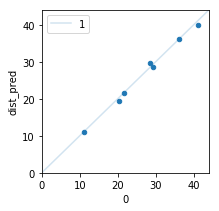

In [341]:
motorcycle_data = height_data.iloc[9:].copy()
motorcycle_data['dist_pred'] = 0.83/motorcycle_data['norm_h']
ax = motorcycle_data.plot.scatter(x='dist', y='dist_pred', figsize=(3,3))
pd.DataFrame([[0,0],[99,99]]).plot(x=0,y=1,ax=ax, alpha=0.2)
ax.set_ylim(0,44); ax.set_xlim(0,44);

In [346]:
motorcycle_data['error'] = motorcycle_data['dist_pred'] - motorcycle_data['dist']
motorcycle_data['% error'] = (motorcycle_data['dist_pred'] - motorcycle_data['dist'])/motorcycle_data['dist']*100
motorcycle_data

,front,side,dist,pixels,norm_h,dist_pred,error,% error
9,10.0,5.0,11.2,72.0,0.075000,11.066667,-0.133333,-1.190476
10,20.0,4.0,20.4,41.0,0.042708,19.434146,-0.965854,-4.734577
11,21.0,5.0,21.6,37.0,0.038542,21.535135,-0.064865,-0.300300
12,28.0,5.0,28.4,27.0,0.028125,29.511111,1.111111,3.912363
13,29.0,4.0,29.3,28.0,0.029167,28.457143,-0.842857,-2.876646
14,36.0,4.0,36.2,22.0,0.022917,36.218182,0.018182,0.050226
15,41.0,4.0,41.2,20.0,0.020833,39.840000,-1.360000,-3.300971


In [393]:
h_error = np.abs(motorcycle_data['% error']).mean()/100
print('error using h to estimate depth is: ', np.round(h_error,3))

error using h to estimate depth is:  0.023


---
## Putting both methods together into a function

In [397]:
14/302

0.046357615894039736

In [399]:
275/604 + 14/302

0.5016556291390728

In [394]:
def estimate_depth(x,y,h):
    """
    x,y,h: bounding box outputs from YOLO (already normalized)
    
    + — — — — — — > x
    |             |
    |    image    |
    |             |
    v — — — — — — +
    y
    
    """
    imx = x
    imy = y + h/2 #to get bottom of bounding box
    
    """
    Method 1, using x,y position of the center bottom of object
    """
    H = 2 # H is the height of the camera, also a scale factor
    a = -0.9 # a is the "bias" term
    yfov = np.pi/1.5*1208/1920
    ycenter = 275/604 + 14/302 #y value of center of camera (i.e. horizon)
    y_pred = H / (np.tan(yfov/2)*((imy/604 - ycenter)/ycenter)) + a
    
    G = 32 # scale factor
    b = -34 # biase
    x_pred = G * imx / imy + b
    
    d_pred1 = np.sqrt(y_pred**2 + x_pred**2)
    
    """
    Method 2, using h of object
    """
    d_pred2 = 0.83/h
    
    """
    Combining them, weighing method 1&2 1:10 using ratio of error
    """
    d_pred_final = (d_pred1 + 10*d_pred2)/11
    
    return d_pred_final
    

0.10643004999369156

---
---
---
### for cars (not used)

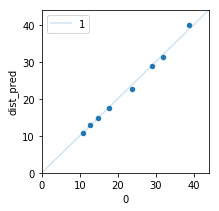

In [340]:
car_data = height_data.iloc[:9].copy()
car_data['dist_pred'] = 0.75/car_data['norm_h']
ax = car_data.plot.scatter(x='dist', y='dist_pred', figsize=(3,3))
pd.DataFrame([[0,0],[99,99]]).plot(x=0,y=1,ax=ax, alpha=0.2)
ax.set_ylim(0,44); ax.set_xlim(0,44);

In [344]:
car_data['error'] = car_data['dist_pred'] - car_data['dist']
car_data['% error'] = (car_data['dist_pred'] - car_data['dist'])/car_data['dist']*100

,front,side,dist,pixels,norm_h,dist_pred,error,% error
0,10.0,4.0,10.8,67.0,0.069792,10.746269,-0.053731,-0.497512
1,12.0,4.0,12.6,56.0,0.058333,12.857143,0.257143,2.040816
2,14.0,5.0,14.9,49.0,0.051042,14.693878,-0.206122,-1.383372
3,17.0,5.0,17.7,41.0,0.042708,17.560976,-0.139024,-0.785449
4,23.0,6.0,23.8,32.0,0.033333,22.500000,-1.300000,-5.462185
5,28.0,7.0,28.9,25.0,0.026042,28.800000,-0.100000,-0.346021
6,31.0,7.0,31.8,23.0,0.023958,31.304348,-0.495652,-1.558655
7,38.0,7.0,38.6,18.0,0.018750,40.000000,1.400000,3.626943
8,41.0,8.0,41.8,16.0,0.016667,45.000000,3.200000,7.655502
